# Deep Q-Network (DQN)

In this exercise, you will implement a Deep Q-Learning Network (DQN) agent that uses a Neural Network (NN) to estimate the action value (Q value) of a state. Deep Q-Learning Network was invented by Google DeepMind in 2013, and it became famous for achieving superhuman performance on 29 out of 49 games on *Atari 2600* games.

The links to DQN papers are at the end in the **References** section.

## Prerequisites

You are expected to have basic familiarity with Machine Learning, Deep Learning, and Reinforcement Learning, especially on following topics:

 * Neural Network
 * Q-Learning
 * (Optional) Convolutional Neural Network

You are also expected to have basic familarity with PyTorch, especially on following modules:

 * `torch.nn`
 * `torch.optim`

## Setup

In [1]:
import copy
import random
from collections import deque

import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from IPython.display import clear_output
%matplotlib inline

In [3]:
USE_CUDA = torch.cuda.is_available()

## Environment

### CartPole

In this notebook, we use the **CartPole** environment from [OpenAI Gym](https://gym.openai.com). In the CartPole environment, the agent has two components: a cart and a pole.

At every timestep, the agent receives +1 reward unless the episode is terminated. The episode terminates if

 1. the cart is too far left or right
 2. the pole  is too far off from its upright position
 3. 200 timesteps passed.

Thus, the agent's goal is to maintain balance so that the pole stays upright. To maintain balance, the agent must move the cart left or right accordingly.

![Cartpole](cartpole.gif)

In [4]:
env_id = 'CartPole-v0'
env = gym.make(env_id)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
print('Observation Space: ', env.observation_space)
print('Action Space: ', env.action_space)

Observation Space:  Box(4,)
Action Space:  Discrete(2)


**State Space Dimensions**: 4
 * $x$: Location of the cart
 * $x'$: Speed of the cart
 * $\theta$: Angle of the pole
 * $\theta'$: Angular Speed of the pole

**Action Space Size**: 2
 * Left
 * Right

**Reward**: +1 for all state

### Wrapper

To follow DeepMind's paper, we implement a **Environment Wrapper**. An environment wrapper changes the environment's behavior. DeepMind clipped the reward to an interval [-1, 1].

In [6]:
class RewardClipWrapper(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)
    def reward(self, r):
        return np.clip(r, -1, 1)

In [7]:
env = RewardClipWrapper(env)

<div class='alert alert-warning'>
In `CartPole`, reward is always 1, so the wrapper actually does nothing.
</div>

## Deep Q-Network (DQN)

Let's implement a neural network with PyTorch. We will use a simple neural network with few layers. The input will be the observation $s=(x, x', \theta, \theta')$, and the output will be the action values $Q(s, \text{left})$ and $Q(s, \text{right})$.

We create a `DQN` class that inherits `torch.nn.Module`. By convention, define the layers in `DQN.__init__()` and define the forward propagation step in `DQN.forward()`.

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dims)
        )

    def forward(self, x):
        return self.layers(x)

## Replay Buffer

In Q-Learning, the agent only looks at each experience once: after taking an action, it uses the experience $(s, a, r, s')$ once and forgets it immediately after the update. **Experience Replay** considers a different approach: the agent remembers the last $D$ experiences by saving them into a "replay memory". Also, instead of updating the parameters with the new experience, the agent updates its parameters by sampling a batch from the replay memory.

This approach has several advantages:

 1. Every experience is used multiple times, so it is more efficient in terms of data.
 2. Experiences are strongly correlated in the Naive DQN. Randomly sampling from replay memory breaks these correlations and thus reduces the variance of the updates.

To implement experience replay, we create a `ReplayBuffer` class. The `ReplayBuffer` needs two functions:

 * `ReplayBuffer.append()` that appends the new experience
 * `ReplayBuffer.sample()` that uniformly samples a batch of experiences from the buffer

We will use Python's `deque` (pronounced "deck", not "dequeue").

In [9]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<div class="alert alert-warning">
Note that `deque` automatically discards the leftmost (first-in) element if it is full.
</div>

## Target Network

**Target Network** $\hat{Q}$ is a method of using a separate network to generate the target $r + \gamma \max_{a'} \hat{Q}(s', a')$. The target network $\hat{Q}$ is updated periodically by cloning the parameters of the original network $Q$.

In PyTorch, you can retrieve the weights of a model with `.state_dict()`, and you can assign weights to a model with `.load_state_dict()`.

```
target_dqn.load_state_dict(dqn.state_dict())
```

## Agent

The `DQNAgent` class is quite long, so let's look at each function separately. It has 7 functions:

 * `__init__`
 * `act`
 * `_compute_td_loss`
 * `_update_parameters`
 * `_plot`
 * `train`
 * `play`

### `__init__`

In the `__init__`, we save the parameters into `self`. These are the parameters:

 * `env`: The environment
 * `dqn`: The Deep Q-Network model
 * `Optimizer`: The optimizer to use - one of `torch.nn.optim` modules
 * `epsilon_schedule`: A function that given a timestep returns `epsilon`
 * `replay_buffer`: An instance of a `ReplayBuffer`
 * `discount_factor`: The discount factor $\gamma$
 * `target_update_rate`: Frequency of updating the target network.
 * `batch_size`: The size of batch sampled from the replay buffer
 * `min_buffer_size`: The minimum size of replay buffer before starting to train

In [10]:
class DQNAgent:
    def __init__(self, env, dqn, Optimizer,
                 epsilon_schedule,
                 replay_buffer,
                 learning_rate=1e-3,
                 discount_factor=0.99,
                 target_update_rate=32,
                 batch_size=32,
                 min_buffer_size=32):
        self.env = env
        self.dqn = dqn
        self.target_dqn = copy.deepcopy(dqn)
        self.optimizer = Optimizer(dqn.parameters(), lr=learning_rate)
        self.epsilon_schedule = epsilon_schedule
        self.replay_buffer = replay_buffer
        self.discount_factor = discount_factor
        self.target_update_rate = target_update_rate
        self.batch_size = batch_size
        self.min_buffer_size = min_buffer_size

### `act`

The `act` function returns an action given a state and an epsilon $\epsilon$ selected $\epsilon$-greedily.

In [11]:
def act(self, state, epsilon):
    if random.random() > epsilon:
        state = torch.FloatTensor(state)
        q_values = self.dqn(state)
        action = q_values.argmax().item()
    else:
        action = self.env.action_space.sample()
    return action

### `_compute_loss`

To compute the loss of a batch of experience, we define `_compute_loss()` function. To adhere to the DeepMind paper example, we should use the Huber Loss (also known as the Smooth L1 Loss), but using a MSE loss seems to work fine in this environment.

In [12]:
def _compute_loss(self):
    state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

    state      = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values = self.dqn(state)
    q_value  = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    next_q_values = self.target_dqn(next_state)
    next_q_value  = next_q_values.max(1)[0]
    target = reward + self.discount_factor * next_q_value * (1 - done)

    loss = (q_value - target.detach()).pow(2).mean()

    return loss

### `_update_parameters`

The `_update_parameters` function updates the parameters of the DQN with the loss calculated in `_compute_loss`.

In [13]:
def _update_parameters(self, loss):
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

### `_plot`

The `_plot` function simply plots the episode reward, losses, and epsilons using `matplotlib`.

In [14]:
def _plot(self, frame_idx, rewards, losses, epsilons):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episodic Reward')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('TD Loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('Epsilon')
    plt.plot(epsilons)
    plt.tight_layout()
    plt.show()

### `train`

The `train` function is function that uses all the functions defined above. At every timestep, the agent:

 1. Update the target DQN if needed
 2. Choose an action with the DQN
 3. Receive (state, reward, done, info) from the environment and adds it to the replay buffer
 4. Sample a batch from the replay buffer
 5. Calculate the loss from the batch
 6. Update the parameters with the batch
 7. If the episode is finished, reset environment.

In [15]:
def train(self, n_steps=10000):
    all_rewards = []
    losses = []
    epsilons = []
    episode_reward = 0

    state = self.env.reset()
    for frame_idx in range(1, n_steps + 1):

        epsilon = self.epsilon_schedule(frame_idx)
        epsilons.append(epsilon)
        action = self.act(state, epsilon)
        next_state, reward, done, _ = self.env.step(action)
        self.replay_buffer.append(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done:
            state = self.env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(self.replay_buffer) >= self.min_buffer_size:
            loss = self._compute_loss()
            self._update_parameters(loss)
            losses.append(loss.item())

        if frame_idx % self.target_update_rate == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())

        if frame_idx % 200 == 0:
            self._plot(frame_idx, all_rewards, losses, epsilons)

### `play`

In the `play` function, we run the episode once with $\epsilon = 0$ (i.e. greedy).

In [16]:
def play(self, render=True):
    done = False
    state = self.env.reset()
    total_reward = 0
    while not done:
        action = self.act(state, epsilon=0)
        next_state, reward, done, _ = self.env.step(action)
        if render:
            self.env.render()
        total_reward += reward
        state = next_state

    return total_reward

Let's add all these functions the `DQNAgent` to see how our implementation performs in `CartPole`.

In [17]:
DQNAgent.act = act
DQNAgent._compute_loss = _compute_loss
DQNAgent._update_parameters = _update_parameters
DQNAgent._plot = _plot
DQNAgent.train = train
DQNAgent.play = play

## Result

In [18]:
def get_epsilon_schedule(start, final, decay):
    return lambda step: final + (start - final) * np.exp(-1. * step / decay)

epsilon_schedule = get_epsilon_schedule(1.0, 0.01, 1000)

In [19]:
dqn = DQN(env.observation_space.shape[0], env.action_space.n)
if USE_CUDA:
    dqn = dqn.cuda()
Adam = optim.Adam
replay_buffer = ReplayBuffer(1000)
agent = DQNAgent(env, dqn, Adam, epsilon_schedule, replay_buffer)

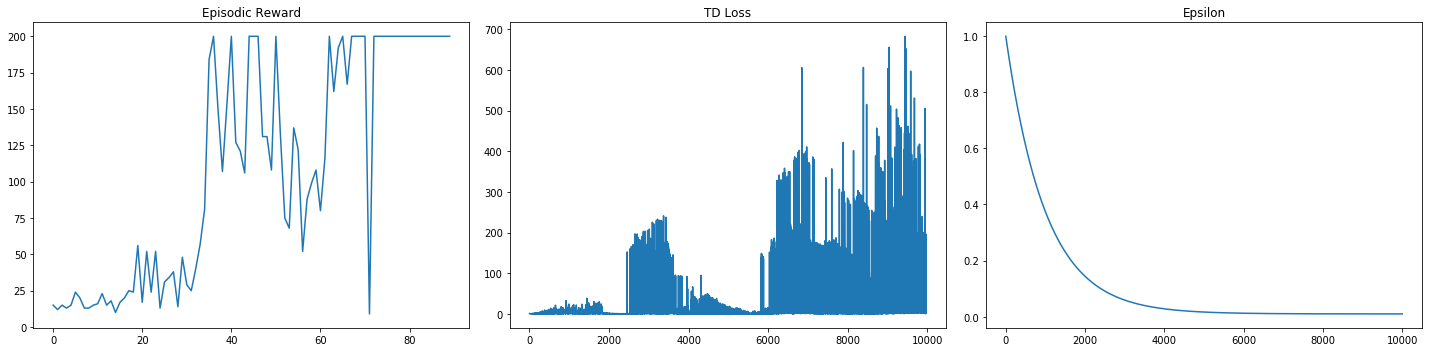

In [20]:
agent.train()

In [21]:
total_reward = agent.play()
print('Total Reward: {}'.format(total_reward))

Total Reward: 200.0


In [22]:
agent.env.close()